In [1]:
import math
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

import sys

sys.path.append("../src/")
sys.setrecursionlimit(2000000)

import utils
from NaCL import NaCLK

In [2]:
cov_encoding = [[0, 1, 2, 3, 4, 5],[10, 11, 12, 13, 14, 15],[20, 21, 22, 23, 24, 25],[30, 31, 32, 33, 34, 35],[40, 41, 42, 43, 44, 45],[50, 51, 52, 53, 54, 55],[60, 61, 62, 63, 64, 65],[70, 71, 72, 73, 74, 75],[80, 81, 82, 83, 84, 85],[90, 91, 92, 93, 94, 95],[60, 61, 62, 63],
                [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]]

# Loading Data

In [3]:
X_train, y_train, X_test, y_test = utils.load_dataset("../data/covtype", "covtype")

In [4]:
X_train.shape

(464808, 104)

In [5]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6])

In [6]:
%%time
from sklearn.naive_bayes import BernoulliNB
NB = BernoulliNB().fit(X_train, y_train)
print(np.average(NB.predict(X_train) == y_train))
print(np.average(NB.predict(X_test) == y_test))

0.6335497667854254
0.6345846026746528
CPU times: user 3.68 s, sys: 1.35 s, total: 5.03 s
Wall time: 2.62 s


### Training Logistic Regression

In [7]:
%%time
clf = LogisticRegression(solver='lbfgs', 
    verbose=True, 
    C = 1,
    multi_class='multinomial',
    max_iter=400, n_jobs=6).fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


CPU times: user 882 ms, sys: 734 ms, total: 1.62 s
Wall time: 5min 21s


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:  5.3min finished


In [8]:
print (np.average(clf.predict(X_test) == y_test), np.average(clf.predict(X_train) == y_train))

0.7098586943426103 0.7075695771157123


### Learning NaCL model

In [9]:
%%time
have_mosek = True # set False if you don't have mosek installed

nacl = NaCLK().setup(clf, X_train, y_train) # , c = 1e-10)
if have_mosek:
    nacl.solve(solver = 'mosek_conif', verbose=1) 
else:
    nacl.solve(solver = 'cvxopt', verbose=1) 

Using solver 'mosek_conif'
 for 1463 free variables
  in 1990 posynomial inequalities.
Solving took 0.141 seconds.
CPU times: user 4.27 s, sys: 559 ms, total: 4.83 s
Wall time: 4.1 s


In [10]:
# Sanity Check to compare NaCL results with Logistic Regression
assert(1.0 == np.average( nacl.predict(X_test)  == clf.predict(X_test )))
assert(1.0 == np.average( nacl.predict(X_train) == clf.predict(X_train)))

## Generating Table for Paper

In [11]:
N = len(cov_encoding)

In [12]:
%%time
from sklearn.metrics import f1_score 

accuracy = lambda x,y: np.mean(x == y)
f1 = lambda x,y: f1_score(x,y.flatten(), average = "weighted")

setting = {
    "repeat": 3, #10
    "k": [i for i in range(0, N, int(0.2*N))],
    "feature_encoding": cov_encoding,
    "prob" : False,# True
    "function": f1 #utils.conditional_likelihood_k
}
data_for_table = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

Using following function: 
<function <lambda> at 0x7f8a20ada950>
Possible features to remove: 12
K = 0
	 R = 0
K = 2
	 R = 0
K = 4
	 R = 0
K = 6
	 R = 0
K = 8
	 R = 0
K = 10
	 R = 0
CPU times: user 4min 29s, sys: 1min 52s, total: 6min 22s
Wall time: 2min 21s


In [13]:
row = []
for method in ["min", "max", "mean", "median","ours"]:
    temp = []
    for k in range(1, 5):
        m = np.mean(100*data_for_table[method][k])
        s = np.std(100*data_for_table[method][k])
        temp.append(np.round(m, 1))
        print(method, k*20, m, s)
        
    row.append(temp)

row = np.array(row)  
bold = np.argmax(row, axis=0)
print("")
for i in range(len(row)):
    line = ""
    for j in range(len(row[i])):
        if bold[j] == i or row[i][j] == row[bold[j]][j]:
            line += "\\textbf{" + str(row[i][j]) + "}"
        else:
            line += str(row[i][j])
        
        line += " & "
    print(line)
    

min 20 64.00868159669997 0.07408239593936256
min 40 57.91394184790649 0.07468985308686019
min 60 52.174356148433354 0.06946083405748976
min 80 46.122284376361755 0.11222692157667369
max 20 49.59706197075932 0.08629097191390488
max 40 44.06724743474022 0.045643678900852205
max 60 41.467536985115906 0.08016766899265833
max 80 37.23632647515252 0.03850107583785262
mean 20 64.05439054275462 0.07061586832203345
mean 40 57.835410454888574 0.02069107070985059
mean 60 52.037927423768885 0.126009701305637
mean 80 46.27727876986943 0.029893640119704655
median 20 64.00868159669997 0.07408239593936256
median 40 57.91394184790649 0.07468985308686019
median 60 52.174356148433354 0.06946083405748976
median 80 46.122284376361755 0.11222692157667369
ours 20 66.12344007478119 0.11514732387283881
ours 40 61.56188318555598 0.0802674760348471
ours 60 56.87118518748417 0.15109036107480636
ours 80 51.70944676567954 0.08202984245594175

64.0 & 57.9 & 52.2 & 46.1 & 
49.6 & 44.1 & 41.5 & 37.2 & 
64.1 & 57.8 & 5

## Generating Missing Data Charts

In [14]:
X_test.shape

(116202, 104)

In [15]:
%%time
setting = {
    "repeat": 1,
    "k": [i for i in range(0, 13, 1)],
    "prob" : True,
    "function": utils.conditional_likelihood_k,
    "feature_encoding": cov_encoding,
}
data_a2 = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

Using following function: 
<function conditional_likelihood_k at 0x7f8a21981488>
Possible features to remove: 12
K = 0
	 R = 0
K = 1
	 R = 0
K = 2
	 R = 0
K = 3
	 R = 0
K = 4
	 R = 0
K = 5
	 R = 0
K = 6
	 R = 0
K = 7
	 R = 0
K = 8
	 R = 0
K = 9
	 R = 0
K = 10
	 R = 0
K = 11
	 R = 0
K = 12
	 R = 0
CPU times: user 3min 17s, sys: 1min 28s, total: 4min 46s
Wall time: 1min 32s


<module 'matplotlib.pyplot' from '/home/pasha/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

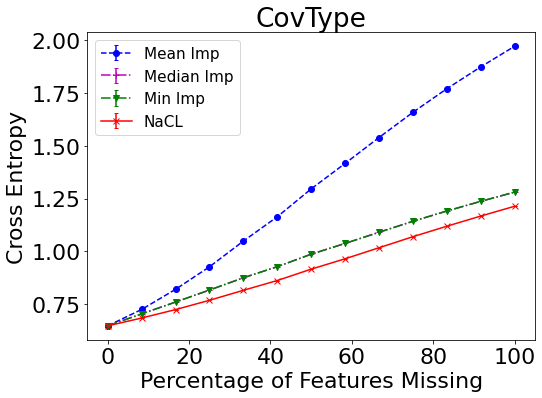

In [16]:
setting = {
    "show": ["min", "mean", "median", "ours"],
    "saveAs": "../results/covType_cross.pdf",
    "title": "CovType",
    "Ylabel": "Cross Entropy"
}
utils.plot_results_paper(data_a2, setting)

In [17]:
%%time
from sklearn.metrics import f1_score 

accuracy = lambda x,y: np.mean(x == y)
f1 = lambda x,y: f1_score(x,y.flatten(), average = "weighted")

setting = {
    "repeat": 1,
    "k": [i for i in range(0, 13, 1)],
    "prob" : False,
    "function": f1,
    "feature_encoding": cov_encoding,
}
data_a3 = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

Using following function: 
<function <lambda> at 0x7f8a20ada7b8>
Possible features to remove: 12
K = 0
	 R = 0
K = 1
	 R = 0
K = 2
	 R = 0
K = 3
	 R = 0
K = 4
	 R = 0
K = 5
	 R = 0
K = 6
	 R = 0
K = 7
	 R = 0
K = 8
	 R = 0
K = 9
	 R = 0
K = 10
	 R = 0
K = 11
	 R = 0
K = 12
	 R = 0
CPU times: user 3min 17s, sys: 1min 22s, total: 4min 39s
Wall time: 1min 44s


<module 'matplotlib.pyplot' from '/home/pasha/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

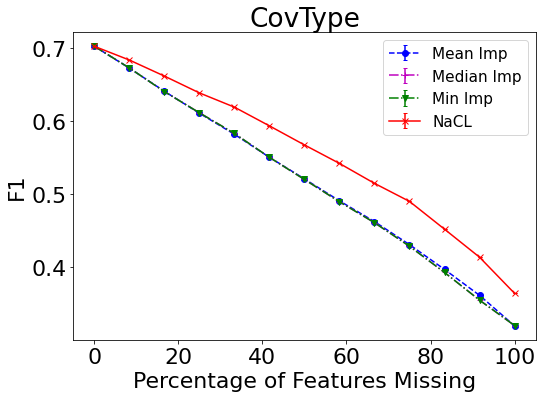

In [18]:
setting = {
    "show": ["min", "ours", "mean", "median"],
    "saveAs": "../results/covtype_accuracy.pdf",
    "title": "CovType",
    "Ylabel": "F1"
}
utils.plot_results_paper(data_a3, setting)

In [19]:
utils.save("../results/data_covtype_result_cross.pickle", data_a2)
utils.save("../results/data_covtype_result_accuracy.pickle", data_a3)